In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from sklearn.metrics import r2_score
from fastai.tabular.all import add_datepart
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import math
import time

tic = time.time()

In [2]:
# # read the stock data at the first run
# # to download the data, need the vpn
# # comment the following codes after the first run
# yf.pdr_override()
# data = pdr.get_data_yahoo("AMZN", start="2022-01-01", end="2023-05-30")
# data # there are 352 data in total using as training and validation data
# # data.to_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/AMZN.csv')

In [3]:
data = pd.read_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/AMZN.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       352 non-null    float64
 1   High       352 non-null    float64
 2   Low        352 non-null    float64
 3   Close      352 non-null    float64
 4   Adj Close  352 non-null    float64
 5   Volume     352 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 19.2 KB


In [4]:
data_2 = pd.DataFrame({'Close':data['Close']})
data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   352 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [5]:
data_2.asfreq("D")[:15]

,Close
Date,
2022-01-03,170.404495
2022-01-04,167.522003
2022-01-05,164.356995
2022-01-06,163.253998
2022-01-07,162.554001
2022-01-08,NaN
2022-01-09,NaN
2022-01-10,161.485992
2022-01-11,165.362000


In [6]:
data_2.asfreq("D", method="ffill")[:15]

,Close
Date,
2022-01-03,170.404495
2022-01-04,167.522003
2022-01-05,164.356995
2022-01-06,163.253998
2022-01-07,162.554001
2022-01-08,162.554001
2022-01-09,162.554001
2022-01-10,161.485992
2022-01-11,165.362000


In [7]:
data_2 = data_2.asfreq("D", method='ffill')
data_2

,Close
Date,
2022-01-03,170.404495
2022-01-04,167.522003
2022-01-05,164.356995
2022-01-06,163.253998
2022-01-07,162.554001
...,...
2023-05-22,115.010002
2023-05-23,114.989998
2023-05-24,116.750000


<Axes: xlabel='Date'>

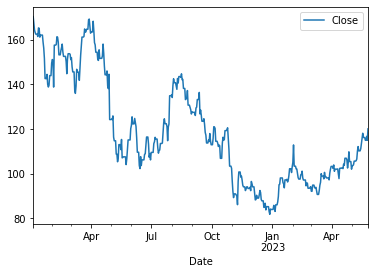

In [8]:
data_2.plot()

In [9]:
# Testing for stationarity
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_2)

(0.5490372560115458, True)

In [10]:
# Spliting the dataset into train and test
train, test = data_2[:int(len(data_2)*0.9)].copy(), data_2[int(len(data_2)*0.9):].copy()

In [11]:
len(test)

51

In [12]:
train.tail()

,Close
Date,
2023-04-01,103.290001
2023-04-02,103.290001
2023-04-03,102.410004
2023-04-04,103.949997
2023-04-05,101.099998


In [13]:
test.head()

,Close
Date,
2023-04-06,102.059998
2023-04-07,102.059998
2023-04-08,102.059998
2023-04-09,102.059998
2023-04-10,102.169998


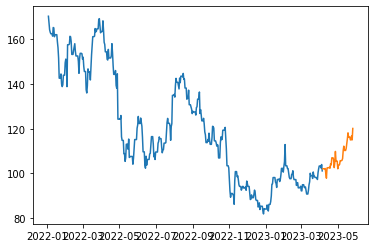

In [14]:
plt.figure()
plt.plot(train)
plt.plot(test)
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/train-test')

In [15]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2560.631, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2426.911, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2562.582, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2392.422, Time=0.69 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2369.709, Time=1.27 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2359.953, Time=1.27 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2355.350, Time=4.02 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=2356.369, Time=14.42 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=15.96 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=2353.684, Time=3.19 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=2358.271, Time=1.22 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=2354.855, Time=8.10 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=11.61 sec
 ARIMA(0,1,1)(5,1,0)[12]       

In [16]:
par_map = arima_model.get_params()
a, b, c = par_map['order'][0], par_map['order'][1], par_map['order'][2]

In [17]:
# check the Best model: ARIMA(1,1,1)(5,1,0)[12]
model = sm.tsa.arima.ARIMA(train, order=(a, b, c))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  458
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1163.251
Date:                Mon, 19 Jun 2023   AIC                           2328.502
Time:                        20:38:16   BIC                           2332.627
Sample:                    01-03-2022   HQIC                          2330.127
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.5156      0.281     33.856      0.000       8.965      10.066
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):              1231.96
Prob(Q):                              0.47   Pr

In [18]:
# Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  458
Model:             SARIMAX(0, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -1170.842
Date:                            Mon, 19 Jun 2023   AIC                           2353.684
Time:                                    20:38:16   BIC                           2378.272
Sample:                                01-03-2022   HQIC                          2363.379
                                     - 04-05-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7901      0.053    -14.882      0.000      -0.894      -0.686
ar.S.L24      -0.5627      0.056     -9.981      0.000      -0.673      -0.452
ar.S.L36      -0.4295      0.060     -7.187      0.000      -0.547      -0.312
ar.S.L48      -0.2666      0.061     -4.384      0.000      -0.386      -0.147
ar.S.L60      -0.1309      0.046     -2.817      0.005      -0.222      -0.040
sigma2        11.0381      0.444     24.859      0.000      10.168      11.908
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               313.18
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 51),index=test.index)
prediction.columns = ['predicted_price']
prediction.tail()

,predicted_price
Date,
2023-05-22,106.016375
2023-05-23,104.847720
2023-05-24,104.910624
2023-05-25,105.596661
2023-05-26,106.441821


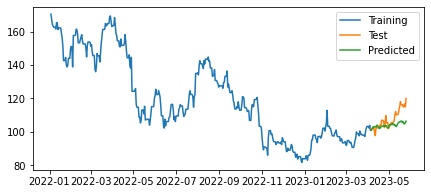

In [20]:
plt.figure(figsize=(7,3))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/prediction.png')

In [21]:
test['predicted_price'] = prediction
r2_score(test['Close'], test['predicted_price'])

-0.0638995818117647

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 7))
prediction.columns = ['predicted_price']
print(prediction.to_latex())
prediction

\begin{tabular}{lr}
\toprule
{} &  predicted\_price \\
\midrule
2023-04-06 &       100.900305 \\
2023-04-07 &       101.400547 \\
2023-04-08 &       102.308534 \\
2023-04-09 &       103.129790 \\
2023-04-10 &       102.841460 \\
2023-04-11 &       103.167069 \\
2023-04-12 &       103.194768 \\
\bottomrule
\end{tabular}



,predicted_price
2023-04-06,100.900305
2023-04-07,101.400547
2023-04-08,102.308534
2023-04-09,103.129790
2023-04-10,102.841460
2023-04-11,103.167069
2023-04-12,103.194768


In [25]:
# final result for future 7 days
prediction = pd.DataFrame(arima_model.predict(n_periods = 58))
prediction.columns = ['predicted_price']
prediction.tail(7)

,predicted_price
2023-05-27,107.321579
2023-05-28,107.526796
2023-05-29,108.024474
2023-05-30,108.349870
2023-05-31,107.856364
2023-06-01,108.718225
2023-06-02,107.953553


In [26]:
real = data.loc['2023-05-26', 'Close']
pred = prediction.loc['2023-06-02', 'predicted_price']
perc = (pred - real) / real * 100
print("The precentage of the future 7th day's price is higher than the prediction day is {0:.2f}%".format(perc))

The precentage of the future 7th day's price is higher than the prediction day is -10.12%


In [24]:
toc = time.time()
print("Total running time is {0:.2f} min".format((toc - tic) / 60))

Total running time is 1.35 min
